# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from math import log10
import geopandas as gpd

# Loading Data

In [2]:
monkeypox_df = pd.read_csv('monkeypox.csv')
covid_df = pd.read_csv('covid.csv')

### Constants

In [3]:
who_alert_covid = pd.to_datetime("30-01-2020", dayfirst=True)
who_alert_monkeypox = pd.to_datetime("14-08-2024", dayfirst=True)

### Display the first few rows of each dataframe to verify loading

In [4]:

print(covid_df.columns)
print(monkeypox_df.columns)



Index(['Date_reported', 'Country_code', 'Country', 'Continent', 'WHO_region',
       'New_cases', 'Cumulative_cases', 'New_deaths', 'Cumulative_deaths'],
      dtype='object')
Index(['location', 'date', 'iso_code', 'total_cases', 'total_deaths',
       'new_cases', 'new_deaths', 'new_cases_smoothed', 'new_deaths_smoothed',
       'new_cases_per_million', 'total_cases_per_million',
       'new_cases_smoothed_per_million', 'new_deaths_per_million',
       'total_deaths_per_million', 'new_deaths_smoothed_per_million'],
      dtype='object')


## Data cleaning and standardization

In [5]:
monkeypox_df.rename(columns={'new_cases': 'New_cases', 'location': 'Country', 'date': 'Date'}, inplace=True)
covid_df.rename(columns={'Date_reported': 'Date'}, inplace=True)

covid_df['Date'] = pd.to_datetime(covid_df['Date'])
monkeypox_df['Date'] = pd.to_datetime(monkeypox_df['Date'])



# First Graphs

## 1 Logged Cumulative Cases in the World

### 1.1 Data preparation

In [6]:
cumulative_cases_covid_any_country = pd.DataFrame(covid_df.groupby('Date')['New_cases'].sum()).reset_index().set_index('Date', drop=False)
cumulative_cases_monkeypox_any_country = pd.DataFrame(monkeypox_df.groupby('Date')['New_cases'].sum()).reset_index().set_index('Date', drop=False)

cumulative_cases_covid_any_country['Cumulative_cases'] = cumulative_cases_covid_any_country['New_cases'].cumsum().apply(lambda x: log10(x))
cumulative_cases_monkeypox_any_country['Cumulative_cases'] = cumulative_cases_monkeypox_any_country['New_cases'].cumsum().apply(lambda x: log10(x))

### 1.2 Plot

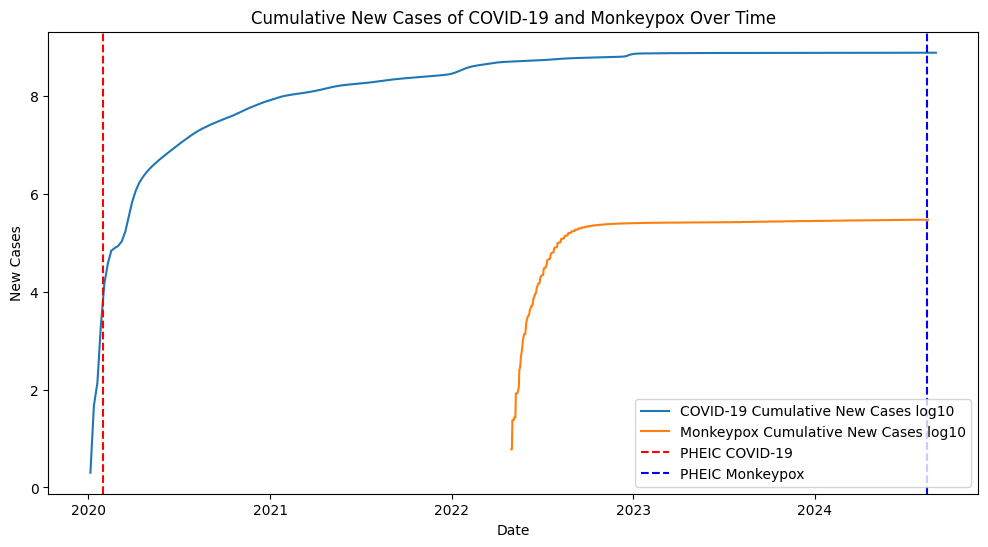

In [7]:
plt.figure(figsize=(12, 6))

plt.plot(cumulative_cases_covid_any_country.index, cumulative_cases_covid_any_country['Cumulative_cases'], label='COVID-19 Cumulative New Cases log10')


plt.plot(cumulative_cases_monkeypox_any_country.index, cumulative_cases_monkeypox_any_country['Cumulative_cases'], label='Monkeypox Cumulative New Cases log10')

plt.axvline(who_alert_covid, color='red', linestyle='--', label='PHEIC COVID-19')
plt.axvline(who_alert_monkeypox, color='blue', linestyle='--', label='PHEIC Monkeypox')

plt.title('Cumulative New Cases of COVID-19 and Monkeypox Over Time')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()

plt.show()

### 2.3 Comparing them - Preparation

In [8]:
cumulative_cases_covid_any_country = cumulative_cases_covid_any_country[cumulative_cases_covid_any_country['Date'] <= who_alert_covid]
cumulative_cases_monkeypox_any_country = cumulative_cases_monkeypox_any_country[cumulative_cases_monkeypox_any_country['Date'] <= who_alert_monkeypox]

### 2.4 Comparing them - Plot

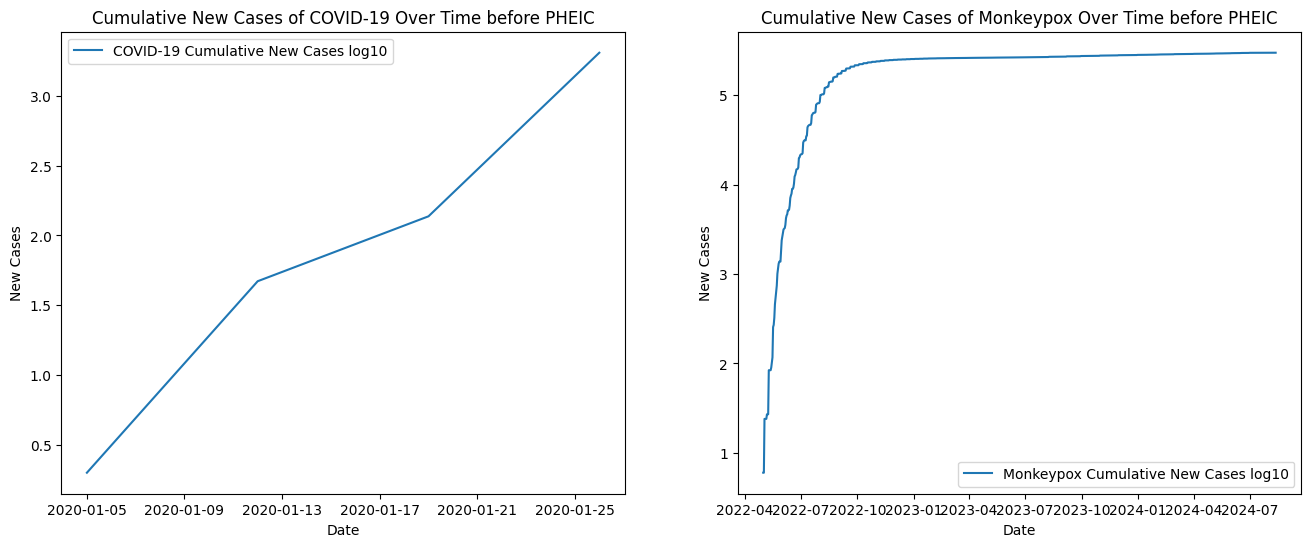

In [19]:
fig = plt.figure(figsize=(16, 6))
fig.add_subplot(1, 2, 1)
plt.plot(cumulative_cases_covid_any_country.index, cumulative_cases_covid_any_country['Cumulative_cases'], label='COVID-19 Cumulative New Cases log10')
plt.title('Cumulative New Cases of COVID-19 Over Time before PHEIC')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()

fig.add_subplot(1, 2, 2)
plt.plot(cumulative_cases_monkeypox_any_country.index, cumulative_cases_monkeypox_any_country['Cumulative_cases'], label='Monkeypox Cumulative New Cases log10')
plt.title('Cumulative New Cases of Monkeypox Over Time before PHEIC')
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.legend()

## 2 Total Cases in Countries before PHEIC

### 2.1 Data Preparation

In [66]:
cumulative_cases_covid_per_country = pd.DataFrame(covid_df[['Date','Country','New_cases']]).set_index('Date', drop=False)
cumulative_cases_monkeypox_per_country = pd.DataFrame(monkeypox_df[['Date','Country','New_cases']]).set_index('Date', drop=False)

cumulative_cases_covid_per_country = cumulative_cases_covid_per_country[cumulative_cases_covid_per_country['Date'] <= who_alert_covid]
cumulative_cases_monkeypox_per_country = cumulative_cases_monkeypox_per_country[cumulative_cases_monkeypox_per_country['Date'] <= who_alert_monkeypox]

cumulative_cases_covid_per_country = pd.DataFrame(cumulative_cases_covid_per_country.groupby('Country')['New_cases'].sum())
cumulative_cases_monkeypox_per_country = pd.DataFrame(cumulative_cases_monkeypox_per_country.groupby('Country')['New_cases'].sum())



world = gpd.read_file('ne_110m_admin_0_countries.shp')

world_covid = world.merge(cumulative_cases_covid_per_country, how="left", left_on="NAME", right_on="Country")
world_monkeypox = world.merge(cumulative_cases_monkeypox_per_country, how="left", left_on="NAME", right_on="Country")

### 2.2 Plot

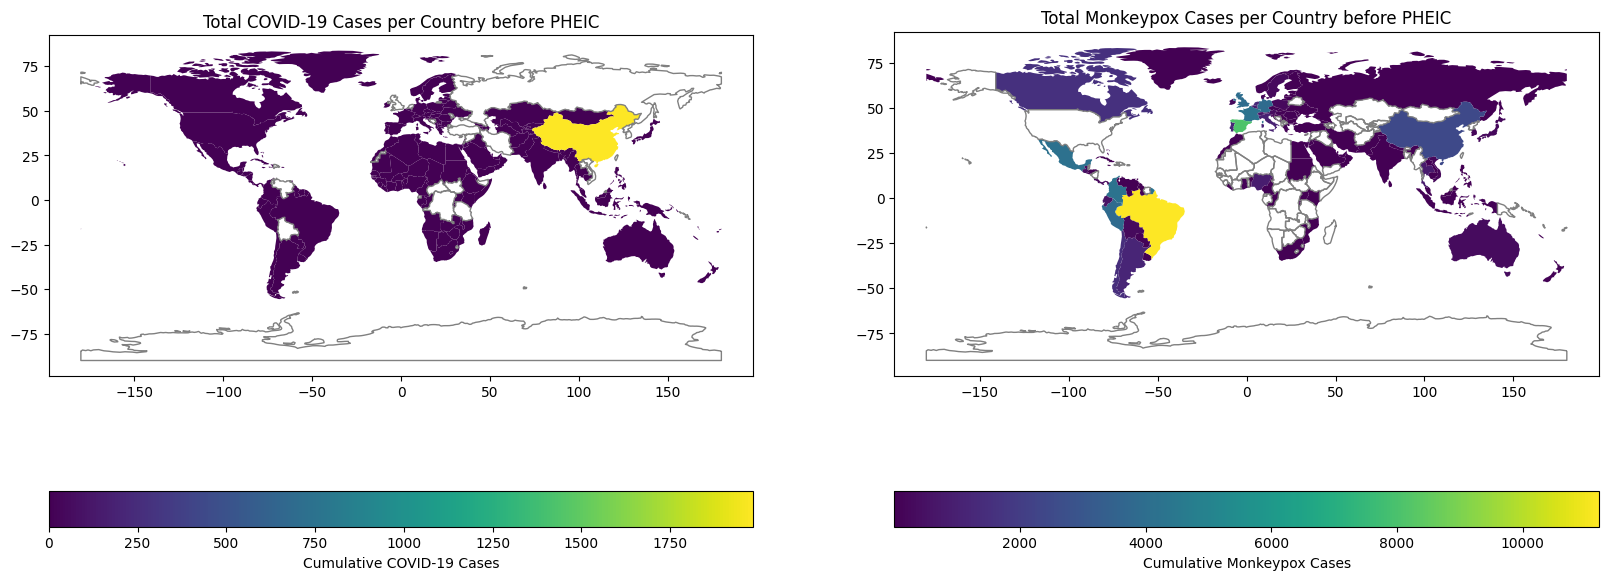

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))


world_covid.plot(column='New_cases', ax=ax[0], legend=True,
                 legend_kwds={'label': "Cumulative COVID-19 Cases",
                              'orientation': "horizontal"})
world_covid[world_covid['New_cases'].isnull()].plot(ax=ax[0], facecolor="none", edgecolor="gray", label='Countries with no cases')
ax[0].set_title('Total COVID-19 Cases per Country before PHEIC')



world_monkeypox.plot(column='New_cases', ax=ax[1], legend=True,
                     legend_kwds={'label': "Cumulative Monkeypox Cases",
                                  'orientation': "horizontal"})
world_monkeypox[world_monkeypox['New_cases'].isnull()].plot(ax=ax[1], facecolor="none", edgecolor="gray", label='Countries with no cases',)
ax[1].set_title('Total Monkeypox Cases per Country before PHEIC')

plt.show()